steps:
1. merge_data based on movie title
2. clean data remove $ and , from revenue
3. encoding
4. split data into train and test
5. train model
6. predict
7. evaluate
8. save model

# Load, clean, and fill data

In [1]:

import datetime
import requests
import pandas as pd
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import pickle
import joblib
import csv
import scipy.stats as stats

In [2]:
def merge_data():
    act_data = pd.read_csv("movie-voice-actors.csv")
    dir_data = pd.read_csv("movie-director.csv")
    rev_data = pd.read_csv("movies-revenue.csv")
    act_data.rename(columns={"movie": "movie_title"}, inplace=True)
    dir_data.rename(columns={"name": "movie_title"}, inplace=True)
    merged_data = pd.merge(rev_data, dir_data, on="movie_title", how="outer")
    merged_data = pd.merge(merged_data,
                           act_data,
                           on="movie_title",
                           how="outer")
    merged_data = merged_data[[col for col in merged_data.columns if col != "revenue"] + ["revenue"]]
    return merged_data

In [3]:
def cleaning(data):
    # removing $ and ,
    data["revenue"] = data["revenue"].str.replace('$', '', regex=False)
    data["revenue"] = data["revenue"].str.replace(',', '', regex=False)
    data["revenue"] = data["revenue"].astype(float)
    return data

In [4]:
def fill(data):   
    data = data.fillna(axis=0, method='ffill')
    data = data.fillna(axis=0, method='backfill')
    return data

In [5]:
def remove_outlier(data):
    z_scores = stats.zscore(data)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    data = data[filtered_entries]
    return data

In [6]:
data = merge_data()
data = cleaning(data)
data = fill(data)

In [7]:
data.to_csv("cleaned_data.csv", index=False)

# Encoding

In [8]:
def encoding(data):
    df = data.copy()
    print(df.columns)
    # rating 
    df = rating_ordinal_encoding(df)
    # release date
    # df = release_date_feature_extraction(df)
    df = mean_encoding_of(df, 'release_date')
    # genre
    df = label_encoding_of(df, 'genre')
    # df = label_encoding_of(df, 'genre')
    # movie title
    df = label_encoding_of(df,'movie_title')
    # voice actor
    df = label_encoding_of(df,'voice-actor')
    # character
    df = label_encoding_of(df,'character')
    # director
    df = mean_encoding_of(df,'director')
    return df

## Mean

In [9]:
def mean_encoding_of(data,col):
    encoder = TargetEncoder()
    data[col] = encoder.fit_transform(data[col],data['revenue'])
    return data

## Label

In [10]:
def label_encoding_of(data,col):
    lbl_encode = LabelEncoder()
    data[col] = lbl_encode.fit_transform(data[col])
    return data;

## Ordinal

In [11]:
def rating_ordinal_encoding(data):
    ord_encode = OrdinalEncoder()
    sr = pd.Series(data['MPAA_rating'])
    mapped_rate = {'R': 1, 'PG': 2, 'PG-13': 3, 'G': 4, 'Not Rated': 3, 'NR': 3}
    # mapped_rate = {'Not Rated': 0, 'G': 1, 'PG': 2, 'PG-13': 3, 'R': 4}
    data['MPAA_rating'] = data['MPAA_rating'].replace(mapped_rate)
    return data


In [12]:
def genre_ordinal_encoding(data):
    mapped_genre = {'Comedy': 9, 'Adventure': 13, 'Drama': 7, 'Action': 12, 'Musical': 15, 'Romantic Comedy': 8,
                    'Horror': 3, \
                    'Thriller/Suspense': 6, 'Crime': 1, 'Documentary': 2, 'Fantasy': 14, 'Black Comedy': 4,
                    'Western': 5, \
                    'Romance': 10, 'Animation': 11}
    data['genre'] = data['genre'].replace(mapped_genre)
    return data

## Feature extraction

In [13]:
def release_date_feature_extraction(data):
    # data['day'] = pd.DatetimeIndex(data['release_date']).day
    data['month'] = pd.DatetimeIndex(data['release_date']).month
    # data['new_movie'] = 0
    data['year'] = data['release_date'].str[-2:].astype(int)
    for i in range(len(data)):
        x = data['year'].iloc[i]
        if x > 23 and x <= 99:
            data.iloc[i, data.columns.get_loc('year')] += 1900
        else:
            data.iloc[i, data.columns.get_loc('year')] += 2000
            
    # for i in range(len(data)):
    #     if data['year'].iloc[i] >= 2005:
    #         data.iloc[i, data.columns.get_loc('new_movie')] =1
    data.drop(['release_date'], axis=1, inplace=True)
    return data

## Modified one hot encoding

In [14]:
def directors_modified_one_hot_encoding(data):
    directors_movies = data['director'].value_counts()
    for x in directors_movies.index:
        if directors_movies[x] >= 3:
            data[x] = 0
            data.loc[data.director == x, x] = 1
    data.drop(['director'], axis=1, inplace=True)
    return data

## Implementing of encoding

In [15]:
df = data.copy()
print(df.columns)
# rating 
df = rating_ordinal_encoding(df)
# release date
# df = release_date_feature_extraction(df)
df = mean_encoding_of(df, 'release_date')
# genre
df = label_encoding_of(df, 'genre')
# df = label_encoding_of(df, 'genre')
# movie title
df = label_encoding_of(df,'movie_title')
# voice actor
df = label_encoding_of(df,'voice-actor')
# character
df = label_encoding_of(df,'character')
# director
df = mean_encoding_of(df,'director')


Index(['movie_title', 'release_date', 'genre', 'MPAA_rating', 'director',
       'character', 'voice-actor', 'revenue'],
      dtype='object')


## Feature selection

In [16]:
def feature_selection(data):
    corr = df.corr()
    # Top 21% Correlation training features with the Value
    top_feature = corr.index[abs(corr['revenue']) > 0.21]
    # Correlation plot
    plt.subplots(figsize=(12, 8))
    top_corr = df[top_feature].corr()
    sns.heatmap(top_corr, annot=True)
    top_feature = top_feature.drop(['revenue'])
    # plt.show()    
    return data

In [17]:
dataX = df.drop(['revenue'],axis=1)
cor_matrix = dataX.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
print(to_drop)
df = df.drop(to_drop, axis=1)

[]


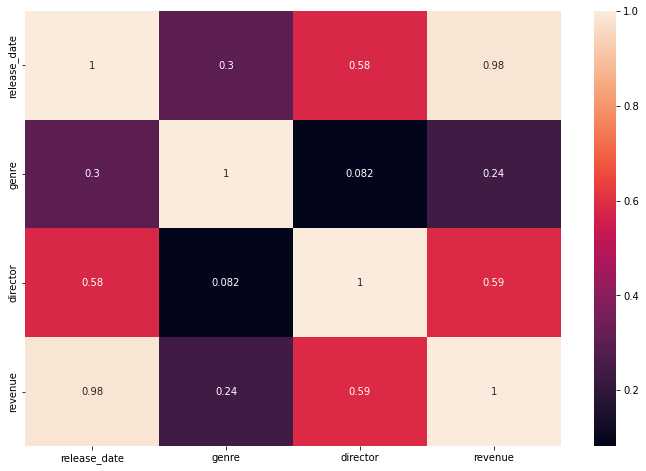

In [18]:
corr = df.corr()
# Top 19% Correlation training features with the Value
top_feature = corr.index[abs(corr['revenue']) > 0.21]
# Correlation plot
plt.subplots(figsize=(12, 8))
top_corr = df[top_feature].corr()
sns.heatmap(top_corr, annot=True)
top_feature = top_feature.drop(['revenue'])
# plt.show()

# Model

## Dividing data x and y 

In [19]:
def divide_data(data):
    y = df['revenue']
    print(top_feature)
    x = df[top_feature]
    return x,y

In [20]:
# dividing data
y = df['revenue']
print(top_feature)
x = df[top_feature]

Index(['release_date', 'genre', 'director'], dtype='object')


## SCALING

In [21]:
def apply_scalling(x):
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    return x

In [22]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

## splitting data to train and test

In [23]:
def split_to_train_test(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
    return x_train,x_test,y_train,y_test

In [24]:

# splitting data to train and test
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=.20,
                                                    shuffle=True,
                                                    random_state=45)


## Ridge regression

In [25]:
ridg = linear_model.Ridge()
ridg.fit(x_train, y_train)

print("")
prediction_ridge_train = ridg.predict(x_train)
print('MSE ridge {Train}', metrics.mean_squared_error(np.asarray(y_train), prediction_ridge_train))
prediction_ridge = ridg.predict(x_test)
print('MSE ridge {Test}', metrics.mean_squared_error(np.asarray(y_test), prediction_ridge))
print("R2 Score ridge", metrics.r2_score(np.asarray(y_test), prediction_ridge))
print("")

true_film_value = np.asarray(y_test)[0]
predicted_film_value = prediction_ridge[0]
print('True value for the first film in the test set is : ' + str(true_film_value))
print('Predicted value for the first film in the test set is : ' + str(predicted_film_value))
print ("Difference between true and predicted value is : " + str(true_film_value - predicted_film_value))


MSE ridge {Train} 1.236196634316165e+16
MSE ridge {Test} 9790494117613652.0
R2 Score ridge 0.9290519541781909

True value for the first film in the test set is : 182029412.0
Predicted value for the first film in the test set is : 148998333.13906726
Difference between true and predicted value is : 33031078.860932738


## Polynomial regression

In [26]:
poly_features = PolynomialFeatures(degree=3)
x_train_poly = poly_features.fit_transform(x_train)
x_test_poly = poly_features.fit_transform(x_test)

poly_model = linear_model.LinearRegression()
poly_model.fit(x_train_poly, y_train)

print("")
prediction_ploy_train = poly_model.predict(x_train_poly)
print('MSE Poly {TRAIN}', metrics.mean_squared_error(y_train, prediction_ploy_train))
prediction_ploy_test = poly_model.predict(x_test_poly)
print('MSE Poly {TEST}', metrics.mean_squared_error(y_test, prediction_ploy_test))
print("R2 Score Poly", metrics.r2_score(y_test, prediction_ploy_test))
print("")

true_film_value = np.asarray(y_test)[0]
predicted_film_value = prediction_ploy_test[0]
print('True value for the first film in the test set is : ' + str(true_film_value))
print('Predicted value for the first film in the test set is : ' + str(predicted_film_value))
print ("Difference between true and predicted value is : " + str(true_film_value - predicted_film_value))


# saving models
joblib.dump(ridg, 'ridg_model')
joblib.dump(poly_model, 'poly_model')
joblib.dump(poly_features, 'poly_features')


MSE Poly {TRAIN} 7836366642526675.0
MSE Poly {TEST} 5316857806687499.0
R2 Score Poly 0.9614707218281999

True value for the first film in the test set is : 182029412.0
Predicted value for the first film in the test set is : 160184656.27032802
Difference between true and predicted value is : 21844755.729671985


['poly_features']

Index(['movie_title', 'release_date', 'genre', 'MPAA_rating', 'director',
       'character', 'voice-actor', 'revenue'],
      dtype='object')
Index(['release_date', 'genre', 'director'], dtype='object')

MSE ridge {All} 1.1847671898052052e+16
R2 Score ridge 0.9593925976670763


MSE ridge {All} 7332464875358842.0
R2 Score ridge 0.9748682818153765



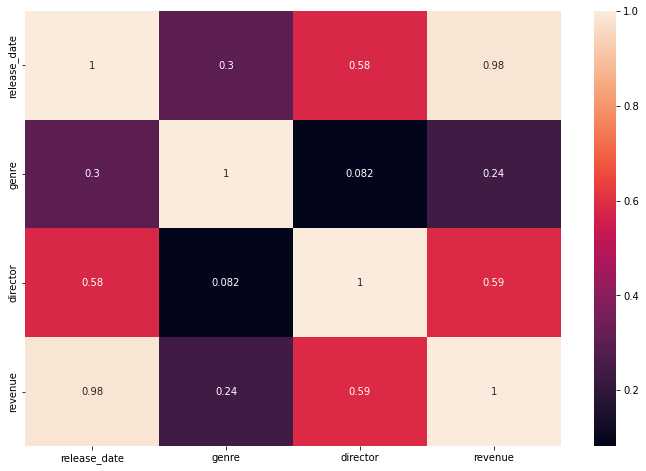

In [27]:
# script to load models and predict
data = merge_data()
data = cleaning(data)
data = fill(data)
data = encoding(data)
data = feature_selection(data)
x,y = divide_data(data)
x = apply_scalling(x)


# load and predict
loaded_poly_features = joblib.load('poly_features')
loaded_poly_model = joblib.load('poly_model')
loaded_ridg_model = joblib.load('ridg_model')

X_val_prep = loaded_poly_features.transform(x)
poly_pred = loaded_poly_model.predict(X_val_prep)
ridg_pred = loaded_ridg_model.predict(x)






print("")
prediction_ridge = ridg.predict(x)
print('MSE ridge {All}', metrics.mean_squared_error(np.asarray(y), prediction_ridge))
print("R2 Score ridge", metrics.r2_score(np.asarray(y), prediction_ridge))
print("")


print("")
prediction_ploy = loaded_poly_model.predict(X_val_prep)
print('MSE ridge {All}', metrics.mean_squared_error(np.asarray(y), prediction_ploy))
print("R2 Score ridge", metrics.r2_score(np.asarray(y), prediction_ploy))
print("")